## Classification of accelerometer data

In this notebook I use a Naive Bayes classifier and a k-nearest neighbour classifier to attempt to distinguish between six types of physical activity using accelerometer data gathered in the study by Kwapisz *et al*.

Raw data published by the reserach group (http://www.cis.fordham.edu/wisdm/includes/datasets/latest/WISDM_ar_latest.tar.gz) is first processed into 10 second intervals.  It is split into a training and test set by randomly assigning two thirds of user ids to the training set and using the rest for the test set.  The reasoning behind splitting the data by user id is that this simulates the the process of training a classifier on available data and then applying it to data gathered from a new group of users.

For each 10 second measurement interval the following features are calculated:<br>
1) The mean absolute change in acceleration per second.<br>
2) The mean of the angle between acceleration vectors for consecutive measurements.<br>
3) Mean acceleration in the x direction.<br>
4) Mean acceleration in the y direction.<br>
5) Mean acceleration in the z direction.<br>

The resulting feature vectors (five values for each 10 second interval) and asociated labels are then passed to each classifier.

Original study citation:
Jennifer R. Kwapisz, Gary M. Weiss and Samuel A. Moore (2010). Activity Recognition using Cell Phone Accelerometers, Proceedings of the Fourth International Workshop on Knowledge Discovery from Sensor Data (at KDD-10), Washington DC.

In [1]:
import sys
import os
import time
import numpy as np
from typing import List
import matplotlib.pyplot as plt

import parse
import features
import plot
import classification
from classification import GaussianNaiveBayesClassifier, KNNClassifier

### Data preprocessing

In [2]:
# Specify path to raw data file.
RAW_DATA_FILE = os.path.join(os.environ["HOME"], "data", "accelerometer", "WISDM_ar_v1.1", "WISDM_ar_v1.1_raw.txt")

# Random number generator seeds
TRAIN_TEST_SHUFFLE_SEED = 6


In [3]:
# Load data
raw_data = parse.file_to_string(RAW_DATA_FILE)
raw_measurements = parse.timepoint_strings_to_timepoint_tuples(
    parse.raw_data_string_to_timepoint_strings(raw_data)
)
user_ids = parse.extract_user_set(raw_measurements)
activities = parse.extract_activity_set(raw_measurements)
print(activities)
print(user_ids)

{'Standing', 'Upstairs', 'Jogging', 'Walking', 'Downstairs', 'Sitting'}
{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36}


In [4]:
# Parse raw data into 10 second intervals.
nanoseconds_in_one_second = 1000000000
nanoseconds_in_10_seconds = 10000000000
intervals: dict = parse.intervals_by_user_and_activity(
    raw_measurements,
    interval_duration_in_nanoseconds=nanoseconds_in_10_seconds,
    maximum_gap_in_nanoseconds=(nanoseconds_in_one_second * 2)
)

In [5]:
# Calculate features for all data intervals
feature_vectors = features.vectors_for_intervals(
    intervals,
    (
        features.mean_absolute_magnitude_change_per_second,
        features.mean_angle_change_per_second,
        features.mean_x_acceleration,
        features.mean_y_acceleration,
        features.mean_z_acceleration
    )
)


In [6]:
# Create train and test sets.
def _shuffled_sequence(length):
    seq = list(range(length))
    np.random.shuffle(seq)  # Numpy does this in place.
    return tuple(seq)

# Create train-test folds of user ids.
np.random.seed(TRAIN_TEST_SHUFFLE_SEED)
sequence = _shuffled_sequence(len(user_ids))
folds_user_ids = classification.train_test_folds(list(user_ids), sequence, 3)


In [7]:
# Create train and test data sets.
train_features = parse.collect_dict_values_by_listed_key_contents(feature_vectors, folds_user_ids[0][0])
test_features = parse.collect_dict_values_by_listed_key_contents(feature_vectors, folds_user_ids[0][1])


### Gaussian Naive Bayes

In [8]:
# Fit Gaussian naive Bayes classifier.
nb_classifier = classification.GaussianNaiveBayesClassifier(train_features, activities)

Percentage accuracy:  83.41257263602748


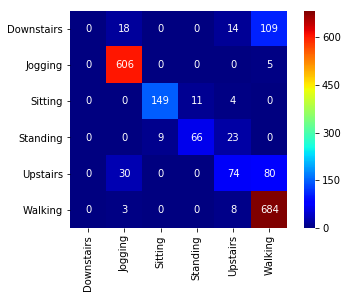

In [9]:
# Make predictions for the test set and plot confusion matrix.
gnb_pairs = nb_classifier.predicted_and_labeled_pairs(test_features)
gnb_matrix, gnb_labels = classification.confusion_matrix_from_pairs(gnb_pairs)
plot.confusion_matrix(gnb_matrix, gnb_labels)
print("Percentage accuracy: ", classification.accuracy_from_confusion_matrix(gnb_matrix) * 100)

#### Potential further work
* Test (e.g. using the Kolmogorov–Smirnov test) how well/badly the features correspond to a Normal distribution and try fitting other continuous distributions.
* Use discretised binning of features rather than a continuous distribution.
* Try fitting multivariate distributions to combinations of features.
* Carry out k-fold cross validation.

### k-Nearest Neighbors

In [10]:
# Instantiate kNN classifier with training data.
k = 11
knn_classifier = KNNClassifier(train_features)

In [11]:
# Make predictions for the test set and plot confusion matrix.
start_time = time.time()
knn_pairs = knn_classifier.predicted_and_labeled_pairs(test_features, k)
print("%s seconds taken to classify test set." % (time.time() - start_time))

59.408931016922 seconds taken to classify test set.


Percentage accuracy:  79.02799788695192


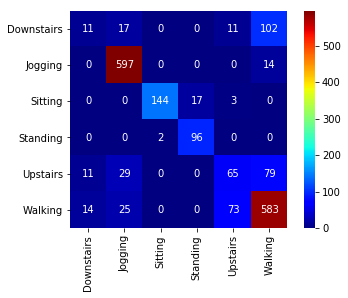

In [12]:
knn_matrix, knn_labels = classification.confusion_matrix_from_pairs(knn_pairs)
plot.confusion_matrix(knn_matrix, knn_labels)
print("Percentage accuracy: ", classification.accuracy_from_confusion_matrix(knn_matrix) * 100)

### Conclusions

Both classifiers are able to distinguish between low (standing and sitting), medium (walking and walking up or down stairs) and high intensity activities (jogging) but sturggle to distinguish activites within these categories.  Both classifiers are partcularly bad at distinguishing between walking and walking up or down stairs.  This is due to greater similarity of movements with these activities but also due to the choice of features used here.  In a real world scenario the problem of distinguishing between similar types of activities would be exercebated as people's movements would not fall so neatly into different categories.
